# CLustering de Clientes para el sector de retail.

## Introducción

En el entorno altamente competitivo del retail moderno, comprender a fondo el comportamiento del cliente se ha convertido en un elemento esencial para la toma de decisiones estratégicas. A diferencia de los métodos supervisados, el aprendizaje no supervisado permite descubrir patrones ocultos en grandes volúmenes de datos sin la necesidad de etiquetas previamente definidas. Esto lo convierte en una herramienta especialmente poderosa cuando se busca identificar segmentos de clientes de manera automática y objetiva.

El aprendizaje no supervisado permite a las empresas del sector retail transformar grandes cantidades de datos transaccionales en información accionable, revelando grupos de clientes con comportamientos similares que de otro modo pasarían desapercibidos. Esta capacidad de segmentación proporciona una ventaja competitiva significativa: facilita la personalización de campañas de marketing, la optimización de estrategias de retención y fidelización, así como una asignación más eficiente de los recursos comerciales.

Este proyecto tiene como objetivo principal segmentar a los clientes de una tienda de retail mediante un análisis RFM (Recency, Frequency, Monetary), una técnica ampliamente utilizada en marketing relacional para evaluar el valor de los clientes con base en su comportamiento de compra. A lo largo de este análisis, se llevarán a cabo diversas etapas clave que incluyen la limpieza y transformación de datos, la ingeniería de características, y la selección óptima del número de clusters mediante distintas metodologías de validación, tales como el método del codo, el coeficiente de silueta y la variación explicada.

La segmentación resultante permitirá a la empresa comprender mejor a su base de clientes y diseñar estrategias diferenciadas que maximicen tanto la experiencia del usuario como el retorno de inversión.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub


In [2]:
# Obtenemos los datos de kaggle
path = kagglehub.dataset_download("hellbuoy/online-retail-customer-clustering")

print("Path to dataset files:", path)

100%|██████████| 7.22M/7.22M [00:00<00:00, 43.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hellbuoy/online-retail-customer-clustering/versions/1


In [3]:
# Creando el dataframe principal

data = pd.read_csv(f'{path}/OnlineRetail.csv', encoding='ISO-8859-1')


## Exploración de datos

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [162]:
data.select_dtypes(include='object').describe()

,InvoiceNo,StockCode,Description,InvoiceDate,Country
count,541909,541909,540455,541909,541909
unique,25900,4070,4223,23260,38
top,573585,85123A,WHITE HANGING HEART T-LIGHT HOLDER,31-10-2011 14:41,United Kingdom
freq,1114,2313,2369,1114,495478


In [163]:
data.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
133158,547729,20682,RED RETROSPOT CHILDRENS UMBRELLA,3,25-03-2011 10:52,3.25,15529.0,United Kingdom
290950,562420,22720,SET OF 3 CAKE TINS PANTRY DESIGN,2,04-08-2011 16:38,10.79,NaN,United Kingdom
269819,560504,21094,SET/6 RED SPOTTY PAPER PLATES,36,19-07-2011 11:47,0.85,13081.0,United Kingdom
338927,566571,22555,PLASTERS IN TIN STRONGMAN,12,13-09-2011 12:49,1.65,17037.0,United Kingdom
108902,545568,90214N,"LETTER ""N"" BLING KEY RING",2,03-03-2011 16:22,0.83,NaN,United Kingdom
65614,541696,22297,HEART IVORY TRELLIS SMALL,1,20-01-2011 18:08,2.46,NaN,United Kingdom
96521,544569,21212,PACK OF 72 RETROSPOT CAKE CASES,3,21-02-2011 12:58,0.55,16980.0,United Kingdom
516023,579843,21621,VINTAGE UNION JACK BUNTING,12,30-11-2011 16:21,8.50,12921.0,United Kingdom
261912,559894,22098,BOUDOIR SQUARE TISSUE BOX,2,13-07-2011 12:06,0.39,14159.0,United Kingdom
63613,541585,22788,BROCANTE COAT RACK,2,19-01-2011 14:22,9.95,14180.0,United Kingdom


## Preprocesamiento de Datos

El preprocesamiento de los datos es una etapa fundamental para garantizar la calidad del análisis y la validez de los resultados. Antes de proceder con la segmentación de clientes, es necesario realizar una depuración cuidadosa del conjunto de datos para asegurar que las observaciones incluidas reflejen únicamente transacciones de venta reales.

Dado que el conjunto de datos corresponde a transacciones ocurridas entre los años 2010 y 2011, se ha definido una fecha de referencia estática para los cálculos de recencia: **2011-12-10**. Esta fecha ha sido seleccionada por su cercanía temporal al periodo final del dataset y servirá como punto de comparación para determinar el tiempo transcurrido desde la última compra de cada cliente.

Durante la exploración inicial de los datos, se identificaron varios registros que no corresponden a ventas efectivas. Entre ellos se incluyen:

- **Devoluciones**: transacciones anuladas por parte del cliente.
- **Cargos bancarios y cargos de envío**: movimientos contables que no reflejan compras de productos.
- **Productos no cobrados**: ítems registrados pero sin facturación asociada.

Dado que el objetivo del análisis es centrarse exclusivamente en el comportamiento de compra efectivo, todos estos registros serán eliminados del conjunto de datos.

Adicionalmente, se detectaron entradas que no contienen un identificador de cliente (`CustomerID`). Estos registros no permiten asociar las transacciones a un individuo específico, lo que imposibilita su inclusión en el análisis RFM. Por tanto, también serán excluidos.

Finalmente, se ha tomado la decisión de restringir el análisis únicamente a los clientes localizados en el **Reino Unido**. Esta decisión se basa en el hecho de que la tienda objeto de estudio opera principalmente en dicho país, y la mayoría de las transacciones registradas provienen de esa región. Esta delimitación geográfica permite obtener una segmentación más precisa y alineada con la realidad comercial del negocio.

Una vez considerados y aplicados estos criterios de limpieza, el conjunto de datos estará preparado para las siguientes etapas del flujo de trabajo, incluyendo la ingeniería de características y la aplicación de técnicas de aprendizaje no supervisado.

In [164]:
#Eliminando valores NaN

data.dropna( subset=['CustomerID'], inplace=True )

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


In [166]:
data.reset_index( drop=True, inplace=True )

data.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,0
Country,0


### Feature Quantity

In [167]:

data.drop( data[ data['Quantity'] <= 0 ].index, inplace=True )


In [168]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,397924.000000,397924.000000,397924.000000
mean,13.021823,3.116174,15294.315171
std,180.420210,22.096788,1713.169877
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


In [169]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 406828
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397924 non-null  object 
 1   StockCode    397924 non-null  object 
 2   Description  397924 non-null  object 
 3   Quantity     397924 non-null  int64  
 4   InvoiceDate  397924 non-null  object 
 5   UnitPrice    397924 non-null  float64
 6   CustomerID   397924 non-null  float64
 7   Country      397924 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.3+ MB


### Feature UnitPrice

In [170]:
data.drop( data[ data['UnitPrice'] <= 0 ].index, inplace=True )

In [171]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,397884.000000,397884.000000,397884.000000
mean,12.988238,3.116488,15294.423453
std,179.331775,22.097877,1713.141560
min,1.000000,0.001000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15159.000000
75%,12.000000,3.750000,16795.000000
max,80995.000000,8142.750000,18287.000000


### Feature StockCode

In [172]:

data.drop( data[ data.StockCode.isin([ 'POST', 'D', 'BANK CHARGES' ])].index, inplace=True )

In [173]:
data.shape

(396773, 8)

### Feature InvoiceDate

In [174]:
data.InvoiceDate = pd.to_datetime( data.InvoiceDate, format='%d-%m-%Y %H:%M' ).dt.date

In [175]:
data.InvoiceDate.sample(3)

,InvoiceDate
130214,2011-05-11
4185,2010-12-03
398645,2011-12-05


### Feature Country

In [176]:
data.Country.value_counts()

,count
Country,
United Kingdom,354282
Germany,8666
France,8041
EIRE,7236
Spain,2422
Netherlands,2322
Belgium,1935
Switzerland,1810
Portugal,1432


In [177]:
data.drop( data[ data.Country != 'United Kingdom' ].index, inplace=True )

## Ingeniería de Características

Una vez finalizado el proceso de limpieza y depuración del conjunto de datos, el siguiente paso consiste en la construcción de variables relevantes que permitan caracterizar a cada cliente en función de su comportamiento de compra. Para este propósito, se empleará el enfoque **RFM (Recency, Frequency, Monetary)**, una técnica ampliamente utilizada en marketing analítico para evaluar el valor y la lealtad de los clientes.

El análisis RFM se basa en tres dimensiones fundamentales:

- **Recency (Recencia):** número de días transcurridos desde la última compra del cliente hasta la fecha de referencia establecida (2011-12-10).
- **Frequency (Frecuencia):** número total de transacciones realizadas por el cliente durante el periodo observado.
- **Monetary (Valor Monetario):** suma total del valor monetario gastado por el cliente en sus compras.

Estas métricas permiten capturar, respectivamente, cuán reciente, cuán frecuente y cuán valioso es un cliente para el negocio, proporcionando una base sólida para la segmentación posterior mediante técnicas de clustering.

En esta sección se construirá un nuevo DataFrame que contendrá los valores RFM para cada cliente identificado. Este conjunto de datos transformado será la base sobre la cual se aplicarán los algoritmos de aprendizaje no supervisado en las etapas siguientes del proyecto.

Este enfoque garantiza que cada cliente esté representado por una estructura numérica coherente y significativa, facilitando la detección de patrones y la agrupación de perfiles similares en clusters homogéneos.

In [178]:
data.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
163077,556903,23322,LARGE WHITE HEART OF WICKER,2,2011-06-15,2.95,14527.0,United Kingdom
397264,580673,22941,CHRISTMAS LIGHTS 10 REINDEER,24,2011-12-05,7.65,13089.0,United Kingdom
50974,543040,21843,RED RETROSPOT CAKE STAND,1,2011-02-02,10.95,17337.0,United Kingdom
102172,549239,22970,LONDON BUS COFFEE MUG,12,2011-04-07,2.55,13102.0,United Kingdom
65737,544847,22713,CARD I LOVE LONDON,12,2011-02-24,0.42,16086.0,United Kingdom
72089,545576,21116,OWL DOORSTOP,6,2011-03-03,4.95,15611.0,United Kingdom
110187,550196,47559B,TEA TIME OVEN GLOVE,10,2011-04-15,1.25,14796.0,United Kingdom
234194,565331,22334,DINOSAUR PARTY BAG + STICKER SET,1,2011-09-02,1.65,16674.0,United Kingdom
148936,555124,22534,MAGIC DRAWING SLATE SPACEBOY,3,2011-05-31,0.42,18204.0,United Kingdom
299562,571496,48194,DOORMAT HEARTS,2,2011-10-17,8.25,13265.0,United Kingdom


In [179]:
#Creación de spent

data['Spent'] = data.Quantity * data.UnitPrice

In [180]:
# Fecha de referencia

reference_date = data.InvoiceDate.max() + pd.Timedelta( days=1 )

reference_date

datetime.date(2011, 12, 10)

In [181]:
df_rfm = data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'Spent': 'sum'                                        # Monetary
}).reset_index()

df_rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

In [182]:
df_rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12747.0,3,11,4196.01
2,12748.0,1,209,33715.73
3,12749.0,4,5,4090.88
4,12820.0,4,4,942.34
...,...,...,...,...
3914,18280.0,278,1,180.60
3915,18281.0,181,1,80.82
3916,18282.0,8,2,178.05
3917,18283.0,4,16,2094.88


# Segmentación de Clientes

Con el conjunto de datos RFM preparado, estamos listos para llevar a cabo la segmentación de clientes mediante técnicas de aprendizaje no supervisado. Esta fase del proyecto tiene como objetivo identificar grupos de clientes con comportamientos de compra similares, lo que permitirá a la empresa desarrollar estrategias diferenciadas y personalizadas para cada segmento.

El proceso de segmentación se compone de varias etapas críticas que detallamos a continuación:



## Normalización de Variables

Dado que las métricas RFM presentan diferentes escalas y magnitudes, es esencial aplicar un proceso de **normalización** para garantizar que cada variable tenga la misma importancia durante el análisis. Se empleará una técnica de escalado, como **StandardScaler** para transformar los valores a una escala uniforme, lo que facilita el desempeño de algoritmos de clustering basados en distancia, como **K-Means**.

In [183]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

rfm_scaled = scaler.fit_transform( df_rfm[['Recency', 'Frequency', 'Monetary']] )

## Selección del Número Óptimo de Clusters

Determinar el número adecuado de clusters es un paso fundamental para obtener segmentaciones significativas. Para ello, se utilizarán distintos métodos de evaluación:

- **Método del Codo (Elbow Method):** evalúa la inercia intra-cluster en función del número de grupos.
- **Coeficiente de Silueta (Silhouette Score):** mide la coherencia de los clusters generados.

Estas métricas facilitarán la selección del número óptimo de grupos que maximizan la separabilidad entre segmentos y minimizan la dispersión dentro de cada uno.

### Método Elbow

In [184]:
from sklearn.cluster import KMeans

kmeans_per_k = [KMeans(n_clusters=k, n_init=30, random_state=42).fit(rfm_scaled)
                for k in range(1, 11)]
inertia = [model.inertia_ for model in kmeans_per_k]


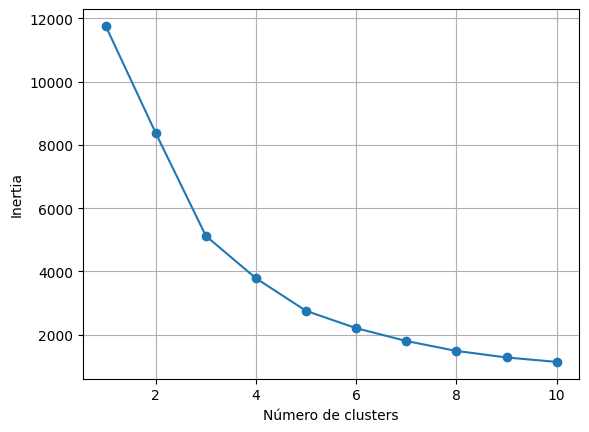

In [185]:

plt.plot( range(1,11), inertia, marker='o' )
plt.xlabel('Número de clusters')
plt.ylabel('Inertia')
plt.grid()
plt.show()


### Método Silhouette score

In [186]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score( rfm_scaled, model.labels_ ) for model in kmeans_per_k[1:]]



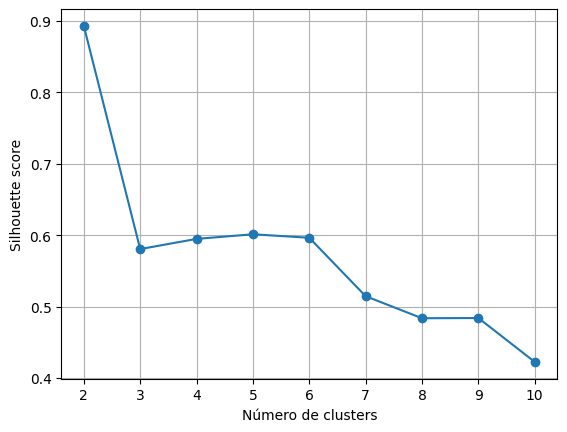

In [187]:
plt.plot( range(2,11), silhouette_scores, marker='o' )
plt.xlabel('Número de clusters')
plt.ylabel('Silhouette score')
plt.grid()
plt.show()
#

### Método silhouette diagram

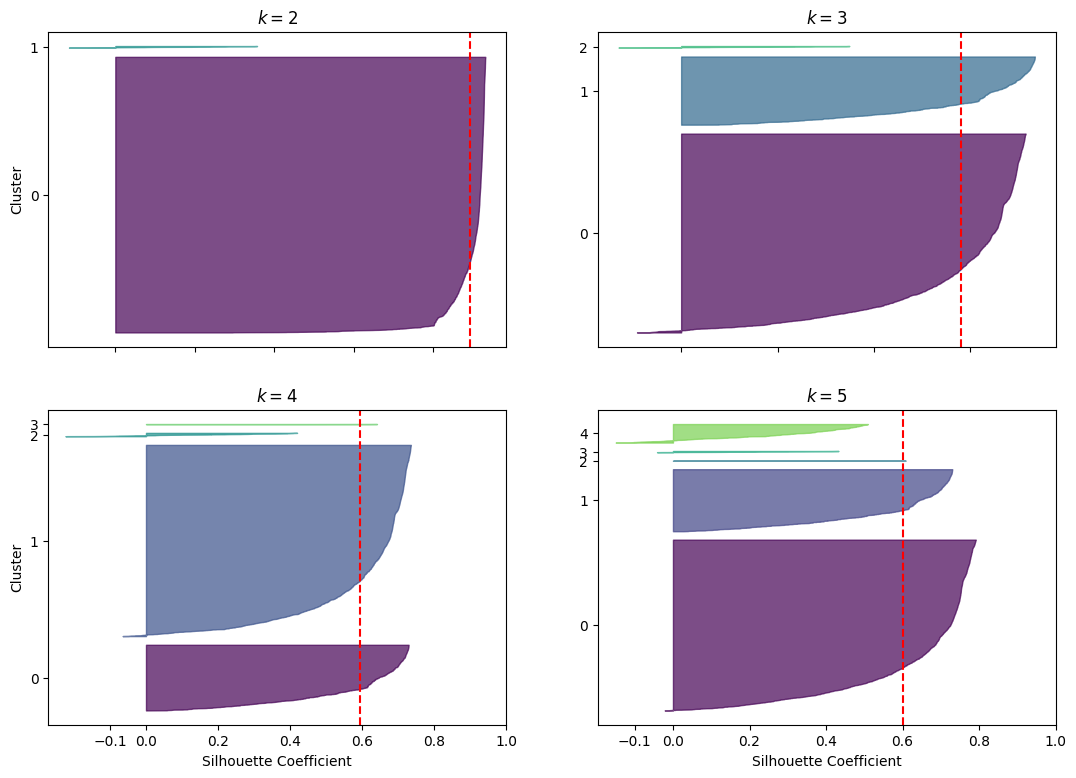

In [188]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(13, 9))

for k in (2, 3, 4, 5):

    plt.subplot(2, 2, (k - 2) + 1 )

    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(rfm_scaled, y_pred)

    padding = len(rfm_scaled) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = plt.cm.viridis(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 4):
        plt.ylabel("Cluster")

    if k in (4, 5):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=False)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

Tras aplicar las técnicas para determinar el número óptimo de clusters, se concluyó que la mejor segmentación se alcanza al agrupar a los clientes en **cuatro clusters**. Esta decisión se fundamenta en el análisis conjunto de dos métodos complementarios:

- **Elbow Method (Método del Codo):** El gráfico de inercia sugiere que los puntos de inflexión en las curvas correspondientes a 3, 4 y 5 clusters podrían representar opciones viables, dado que en esas zonas se observa una disminución significativa en la varianza intra-cluster. Sin embargo, la interpretación de este método puede ser subjetiva al no tener un punto de codo perfectamente definido.

- **Silhouette Score (Coeficiente de Silueta):** Este indicador proporciona una métrica más objetiva de la calidad del agrupamiento al evaluar qué tan similares son los puntos dentro de un cluster respecto a otros clusters. En este caso, el análisis de las gráficas de silueta muestra que **cuatro clusters** presentan la mejor coherencia interna, lo cual se evidencia en la cercanía de los extremos de las siluetas individuales con respecto a la línea promedio, lo que indica una buena separación entre grupos y una baja superposición.

Con base en estos hallazgos, se justifica la elección de **k = 4** como el número óptimo de clusters para continuar con la segmentación y análisis de clientes.

## Aplicación del Algoritmo de Clustering

Una vez definido el número de clusters, se procederá a aplicar el algoritmo de clustering **K-Means** sobre los datos normalizados. Cada cliente será asignado a un grupo específico con base en la similitud de sus métricas RFM.



In [189]:

df_rfm['Cluster'] = kmeans_per_k[3].labels_

In [190]:
df_rfm['Cluster'].unique()

array([2, 1, 0, 3], dtype=int32)

In [191]:
df_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(1)

,Recency,Frequency,Monetary,CustomerID
Cluster,,,,
0,245.1,1.6,526.5,988
1,41.9,4.4,1581.5,2877
2,12.8,43.9,31501.2,51
3,3.7,36.0,207560.2,3


## Visualización de Clusters

Se utilizará **PCA (Análisis de Componentes Principales)** para reducción de dimensionalidad para proyectar los datos en dos dimensiones y facilitar la visualización de los grupos formados. Esta visualización es clave para validar visualmente la calidad de la segmentación y explorar la distribución de los clientes en el espacio reducido.

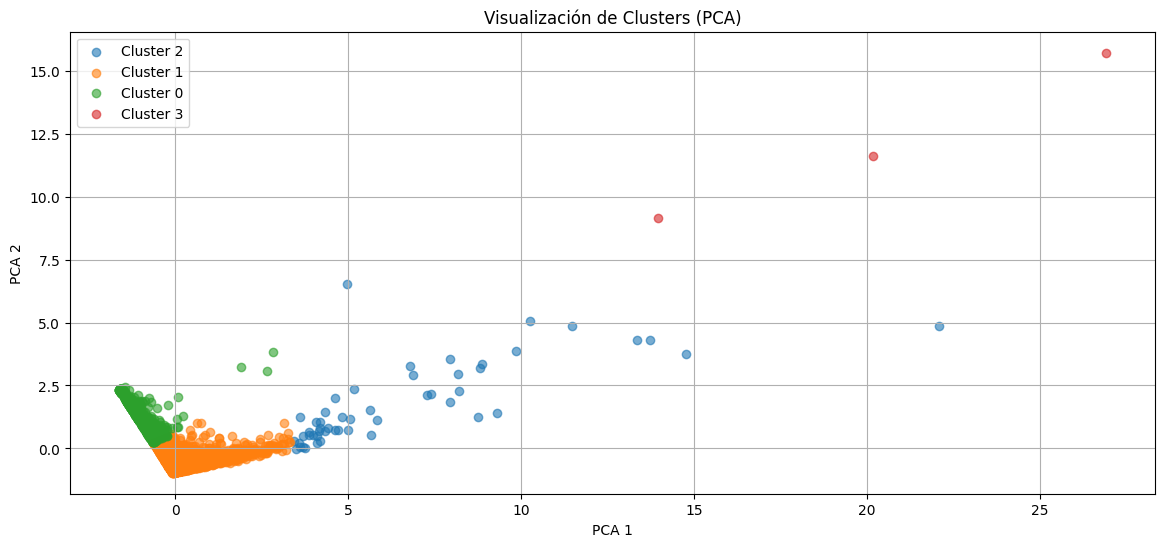

In [192]:
from sklearn.decomposition import PCA

# Reducir dimensiones a 2 componentes
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Crear DataFrame para graficar
df_rfm['PCA1'] = rfm_pca[:, 0]
df_rfm['PCA2'] = rfm_pca[:, 1]

# Graficar
plt.figure(figsize=(14, 6))
for cluster in df_rfm['Cluster'].unique():
    subset = df_rfm[df_rfm['Cluster'] == cluster]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=f'Cluster {cluster}', alpha=0.6)

plt.title('Visualización de Clusters (PCA)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid(True)
plt.show()

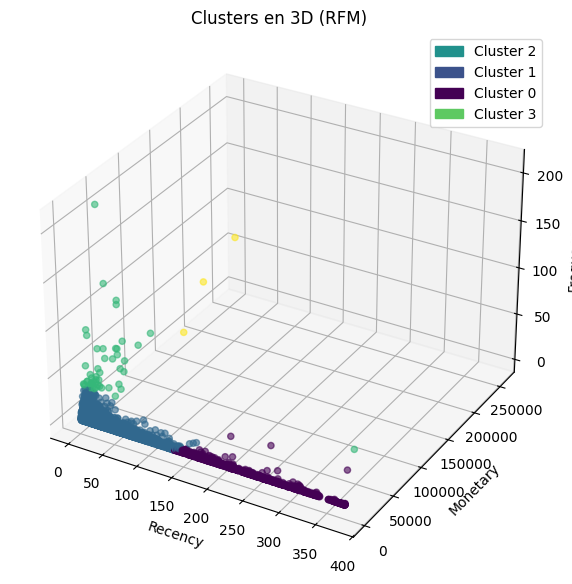

In [193]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(13, 7))
ax = fig.add_subplot(111, projection='3d')

# Colores por cluster
clusters = df_rfm['Cluster'].unique()
colors = plt.cm.viridis(df_rfm['Cluster'] / df_rfm['Cluster'].nunique())

# Graficar
scatter = ax.scatter(df_rfm['Recency'], df_rfm['Monetary'], df_rfm['Frequency'],
                     c=df_rfm['Cluster'], cmap='viridis', alpha=0.6)

# Etiquetas de ejes
ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Frequency')
plt.title('Clusters en 3D (RFM)')

# Leyenda manual
handles = [mpatches.Patch(color=plt.cm.viridis(i / len(clusters)), label=f'Cluster {i}')
           for i in clusters]
plt.legend(handles=handles, loc='upper right')

plt.show()


# Análisis de los Clusters

Finalmente, se realizará un análisis descriptivo de cada uno de los clusters resultantes. Se interpretarán las métricas promedio de recencia, frecuencia y valor monetario dentro de cada grupo para identificar patrones característicos.


In [194]:
# Esta función nos ayuda a calcular los días transcurridos entre la primera y la última compra de un usuario
# Esto nos puede servir para darnos una idea del tiempo que un usuario tiene realizando compras
def days_between( row, df_users ):
  days = df_users[ df_users.CustomerID == row.CustomerID ].InvoiceDate.max() - df_users[ df_users.CustomerID == row.CustomerID ].InvoiceDate.min()
  return days.days



## Análisis de Cluster 0

In [195]:
# Obtenemos lows valores RFM de los usuarios del cluster 0
df_rfm_cluster_0 = df_rfm[ df_rfm['Cluster'] == 0 ]

# Obtenemos los datos de las compras de los usuarios pertenecientes al cluster 0
df_users_cluster_0 = data[ data.CustomerID.isin( df_rfm_cluster_0.CustomerID ) ]

In [196]:
df_rfm_cluster_0.loc[ : ,'DaysBetwen'] = df_rfm_cluster_0.apply( lambda x: days_between(x, df_users_cluster_0), axis=1 )

<ipython-input-196-c624bb96e776>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm_cluster_0.loc[ : ,'DaysBetwen'] = df_rfm_cluster_0.apply( lambda x: days_between(x, df_users_cluster_0), axis=1 )


In [197]:
df_rfm_cluster_0.describe()

,CustomerID,Recency,Frequency,Monetary,Cluster,PCA1,PCA2,DaysBetwen
count,988.000000,988.000000,988.000000,988.000000,988.0,988.000000,988.000000,988.000000
mean,15593.929150,245.127530,1.589069,526.518108,0.0,-0.990426,1.224854,28.907895
std,1591.004389,66.959937,1.496081,1958.263994,0.0,0.383969,0.598298,53.786536
min,12821.000000,138.000000,1.000000,3.750000,0.0,-1.617460,0.236007,0.000000
25%,14246.500000,186.750000,1.000000,164.125000,0.0,-1.235757,0.712715,0.000000
50%,15553.000000,240.500000,1.000000,306.340000,0.0,-0.996436,1.179111,0.000000
75%,16963.500000,296.000000,2.000000,510.025000,0.0,-0.742470,1.654102,36.250000
max,18281.000000,374.000000,34.000000,44534.300000,0.0,2.820112,3.818095,224.000000


### Análisis General del Comportamiento de Compra

A partir del análisis exploratorio de la tabla de métricas agregadas por cliente, se obtienen hallazgos relevantes que permiten comprender de forma más profunda el comportamiento general de los usuarios:

- **Recencia:** En promedio, los clientes llevan más de **140 días sin realizar una compra**, lo que refleja una base de usuarios con un nivel de inactividad significativo.

- **Frecuencia:** El **75% de los clientes realiza únicamente entre una y dos compras al año**, lo que sugiere un bajo nivel de recurrencia en las transacciones y posibles debilidades en la fidelización o el modelo de recompra.

- **Rango entre compras (DaysBetween):** Esta variable, que mide los días transcurridos entre la primera y la última compra de cada usuario, revela que aproximadamente **el 50% de los clientes realizaron una sola compra**, tras la cual no volvieron a interactuar con la tienda. Esto podría ser indicativo de una experiencia poco satisfactoria, falta de retención, o simplemente una compra puntual sin intención de continuidad.

Sin embargo, no todo el panorama es negativo. También se identificó que:

- **El 25% de los usuarios presentan una frecuencia de compra mayor o igual a dos**, lo que sugiere cierto nivel de compromiso con la tienda.
- **Otro 25% de los usuarios no son completamente nuevos**, ya que su valor en la métrica `DaysBetween` muestra intervalos máximos de hasta **224 días** entre su primera y última compra, lo cual indica una permanencia prolongada y potencial para reactivación.

Dado esto, se considera relevante realizar un análisis más profundo sobre aquellos usuarios cuya frecuencia de compra es **igual o mayor a 4**. Evaluar sus patrones de comportamiento, valores monetarios y antigüedad permitirá determinar si representan una oportunidad estratégica para ser reactivados mediante campañas específicas de retención o marketing personalizado.

In [198]:
# Obtenemos los valores unicos de compra para los usuarios con frecuencia de compra superior a 4

df_rfm_cluster_0[ df_rfm_cluster_0.Frequency >= 4 ].Frequency.value_counts()



,count
Frequency,
4,26
6,8
5,8
8,2
9,2
7,2
12,1
34,1



Al examinar más de cerca el subconjunto de usuarios con una **frecuencia de compra superior a la media dentro del cluster**, se identificaron **50 clientes** cuya actividad destaca en comparación con el resto de la muestra.


In [199]:
# Obtenemos las estadisticas generales de los usuarios con una frecuencia de compra superior a 4
df_rfm_cluster_0[ df_rfm_cluster_0.Frequency >= 4 ].sort_values( by='Monetary', ascending=False ).describe()

,CustomerID,Recency,Frequency,Monetary,Cluster,PCA1,PCA2,DaysBetwen
count,50.000000,50.000000,50.00000,50.000000,50.0,50.000000,50.000000,50.000000
mean,16125.600000,215.600000,5.72000,1398.344600,0.0,-0.410714,1.090507,116.060000
std,1578.522585,57.658035,4.41722,1425.049398,0.0,0.448906,0.580896,59.922879
min,12845.000000,150.000000,4.00000,70.020000,0.0,-1.050774,0.409923,0.000000
25%,15139.000000,173.250000,4.00000,543.102500,0.0,-0.638470,0.691700,69.250000
50%,15901.000000,193.000000,4.00000,1002.510000,0.0,-0.425586,0.854986,112.500000
75%,17491.500000,259.250000,6.00000,1616.562500,0.0,-0.259210,1.415712,165.000000
max,18260.000000,373.000000,34.00000,7832.470000,0.0,1.901437,3.245844,219.000000


### Evaluación del Cluster: Clientes Inactivos de Bajo Valor

Una vez filtrados los usuarios más activos dentro de este cluster, es posible realizar un análisis más claro y preciso. Si bien se identificaron algunos clientes con una frecuencia de compra superior al promedio del grupo, los resultados revelan que no representan un segmento particularmente valioso en términos monetarios: el gasto anual de estos usuarios oscila entre **70 y 1,600 unidades monetarias**, lo cual los sitúa dentro del rango típico de comportamiento observado en clientes comunes.

Desde una perspectiva estratégica, estos usuarios podrían considerarse como **potenciales candidatos para reactivación**. Una recomendación viable sería implementar una campaña de correo electrónico personalizada en la que se les presenten **productos en tendencia o promociones relevantes**, con el objetivo de recuperar su atención y fomentar una nueva interacción con la tienda.

Al observar el comportamiento general de este cluster, emergen varios patrones que refuerzan la idea de que estamos ante un grupo predominantemente inactivo:

- **Recencia:** El histograma de la variable `Recency` muestra claramente que **todos los usuarios llevan al menos seis meses sin realizar ninguna compra**, lo cual indica una prolongada inactividad comercial.

- **DaysBetween:** Esta variable, que representa los días transcurridos entre la primera y la última compra de cada cliente, exhibe una distribución concentrada en el valor cero. Esto significa que, para la mayoría de los usuarios del cluster, **la primera y única compra fue realizada en un mismo día**, sin evidencia de recurrencia posterior.

Con base en estos hallazgos, se concluye que este cluster está compuesto en su mayoría por **clientes inactivos y de bajo valor estratégico**. Aunque no representan una prioridad para campañas intensivas de fidelización, podrían ser objeto de iniciativas ligeras y automatizadas de marketing que busquen reactivar, con bajo costo, a aquellos usuarios con un historial de interacción mínima.

## Análisis del Cluster 1: El Comportamiento Estándar del Cliente Promedio

El **Cluster 1** adquiere una importancia estratégica considerable dentro del análisis, ya que representa **el grupo más numeroso de toda la segmentación**. Esta característica lo convierte en un referente clave para entender el comportamiento predominante de la clientela de la tienda.

Dado su tamaño, el comportamiento observado en este cluster puede ser interpretado como **el patrón "normal" o promedio** de los clientes. En consecuencia, **las conclusiones extraídas de este grupo tienen un impacto directo y potencialmente significativo sobre la dirección comercial del negocio**. Cualquier tendencia detectada aquí, ya sea positiva o negativa, debe ser considerada cuidadosamente al momento de diseñar políticas comerciales, promociones, estrategias de fidelización o mejoras en la experiencia de compra.

Por lo tanto, este cluster actúa como un **termómetro del desempeño general del negocio**, y su análisis detallado es esencial para orientar decisiones que afecten al grueso de la base de clientes. Comprender su dinámica puede ayudar a identificar oportunidades de optimización, prever riesgos y reforzar los puntos fuertes del modelo actual de atención y comercialización.

In [200]:
# Obtenemos los datos RFM de los usuarios pertenecientes a este cluster
df_rfm_cluster_1 = df_rfm[ df_rfm['Cluster'] == 1 ]

# Obtenemos los datos de las compras de los usuarios pertenecientes al cluster 1
df_users_cluster_1 = data[ data.CustomerID.isin( df_rfm_cluster_1.CustomerID ) ]

In [201]:
# Obtenemos losn días entre la primera y la última compra

df_rfm_cluster_1.loc[:,'DaysBetwen'] = df_rfm_cluster_1.apply( lambda row: days_between(row, df_users_cluster_1 ), axis=1 )

<ipython-input-201-a3898f3d3596>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm_cluster_1.loc[:,'DaysBetwen'] = df_rfm_cluster_1.apply( lambda row: days_between(row, df_users_cluster_1 ), axis=1 )


In [202]:
df_rfm_cluster_1.describe()

,CustomerID,Recency,Frequency,Monetary,Cluster,PCA1,PCA2,DaysBetwen
count,2877.000000,2877.000000,2877.000000,2877.000000,2877.0,2877.000000,2877.000000,2877.000000
mean,15554.720542,41.919360,4.414668,1581.508214,1.0,0.204029,-0.465194,162.551616
std,1568.100869,35.075625,4.319245,2067.957728,0.0,0.606390,0.314265,132.013854
min,12747.000000,1.000000,1.000000,6.200000,1.0,-0.630696,-0.965544,0.000000
25%,14201.000000,13.000000,2.000000,388.280000,1.0,-0.182768,-0.709936,2.000000
50%,15573.000000,31.000000,3.000000,871.540000,1.0,0.036166,-0.527387,175.000000
75%,16903.000000,64.000000,6.000000,1936.070000,1.0,0.393537,-0.276315,279.000000
max,18287.000000,164.000000,31.000000,28337.380000,1.0,3.324206,1.006967,372.000000




A diferencia del cluster 0, esta tabla revela características significativamente distintas que reflejan un comportamiento más activo y valioso por parte de los clientes.

- **Recency:** La variable `Recency` indica que el **75% de los usuarios realizaron su última compra hace menos de 70 días**, lo que denota una alta frecuencia de interacción reciente con la tienda, un claro indicativo de clientes comprometidos y activos.

- **Frecuencia de Compra:** La frecuencia promedio de compra también supera notablemente la observada en el cluster 0, situándose entre **2 y 6 compras durante el año para el 50% de los usuarios**. Este patrón sugiere un nivel de recurrencia y fidelidad general.

- **Ingreso Promedio por Usuario (ARPU):** Como consecuencia directa de esta mayor actividad, el ingreso promedio por usuario en este cluster es de **1,581.05 unidades monetarias**, cifra que excede significativamente al ARPU del cluster 0, lo que destaca la importancia económica de este grupo.

- **DaysBetween:** Otro dato relevante es el tiempo transcurrido entre la primera y última compra. Para el 50% de los usuarios, este período supera los **170 días**, evidenciando que los clientes en este cluster no solo realizan una compra única, sino que mantienen una relación sostenida con la tienda, comprando de manera constante y recurrente a lo largo del tiempo.

No obstante, es importante señalar que, aunque predominan clientes con comportamiento recurrente, existe un segmento dentro del cluster que solo ha realizado una compra. En la siguiente sección se explorarán las causas y características de estos usuarios para entender mejor su perfil y posibles acciones a tomar.

In [203]:
# Obtenemos la cantidad de usuarios para cada frecuencia de compra de 1 a 10
df_rfm_cluster_1.Frequency.value_counts().sort_index().head(10)


,count
Frequency,
1,690
2,536
3,394
4,328
5,207
6,151
7,127
8,85
9,58


A partir de la tabla anterior, se puede observar que **la proporción de usuarios que solo han realizado una única compra dentro del Cluster 1 es mínima**.

In [204]:
# Obtenemos el rango de fechas en la que los usuarios realizaron su unica compra
f_min = df_users_cluster_1[ df_users_cluster_1.CustomerID.isin( df_rfm_cluster_1[ df_rfm_cluster_1.Frequency == 1 ].CustomerID ) ].min()
f_max = df_users_cluster_1[ df_users_cluster_1.CustomerID.isin( df_rfm_cluster_1[ df_rfm_cluster_1.Frequency == 1 ].CustomerID ) ].max()

print(f'La fecha más antigua en la que un usuario realizó una compra es: {f_min.InvoiceDate}')
print(f'La fecha más reciente en la que un usuario realizó una compra es: {f_max.InvoiceDate}')

La fecha más antigua en la que un usuario realizó una compra es: 2011-07-25
La fecha más reciente en la que un usuario realizó una compra es: 2011-12-08




Como se puede observar, los usuarios que únicamente han realizado una compra dentro de este cluster tienden a ser clientes relativamente nuevos. Esta característica sugiere que existe un alto potencial de crecimiento en su comportamiento de compra, ya que es razonable esperar que estos usuarios realicen compras adicionales en un futuro cercano, conforme se familiaricen más con la oferta y la experiencia de la tienda.

En conjunto, el análisis permite concluir que el **Cluster 1 agrupa a los usuarios con un comportamiento más estándar y representativo del cliente típico de la tienda**. Estos clientes mantienen una actividad constante durante el año, comprando productos de manera recurrente y contribuyendo significativamente al ingreso promedio de la empresa.

Por tanto, este segmento representa un pilar fundamental para la sostenibilidad del negocio, y su adecuada gestión a través de estrategias de fidelización, promoción y personalización será clave para maximizar su valor a largo plazo.

## Análisis del Cluster 2: Perfil de Usuarios con Comportamiento Particular

El Cluster 2, debido a su tamaño reducido, representa un segmento de clientes con características y patrones de compra que difieren notablemente de los clusters más grandes y comunes. La pequeña proporción de usuarios en este grupo sugiere que se trata de un nicho con un comportamiento bastante particular, que merece un análisis detallado y específico.

Este cluster probablemente incluye a usuarios con hábitos de compra atípicos, ya sea por la frecuencia, el valor monetario, la recencia o una combinación de estas variables. Identificar y comprender las particularidades de estos clientes puede ofrecer insights valiosos para diseñar estrategias personalizadas que optimicen su experiencia y maximicen su valor para la empresa.

Dado que este grupo puede contener tanto a clientes altamente leales y valiosos, como a usuarios con comportamiento irregular o incluso inactivos, es fundamental realizar un análisis exhaustivo de sus métricas RFM para entender sus dinámicas específicas y determinar acciones estratégicas orientadas a su retención o recuperación.

In [205]:
# Obtenemos los datos RFM de los usuarios pertenecientes a este cluster
df_rfm_cluster_2 = df_rfm[ df_rfm['Cluster'] == 2 ]

# Obtenemos los datos de las compras de los usuarios pertenecientes al cluster 2
df_users_cluster_2 = data[ data.CustomerID.isin( df_rfm_cluster_2.CustomerID ) ]
# Calculamos los dias transcurridos entre la primera y la última compra

In [206]:
# Calculamos los dias transcurridos entre la primera y la última compra
df_rfm_cluster_2.loc[ : ,'DaysBetwen'] = df_rfm_cluster_2.apply( lambda row: days_between(row, df_users_cluster_2 ), axis=1 )

<ipython-input-206-b3a338e302b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm_cluster_2.loc[ : ,'DaysBetwen'] = df_rfm_cluster_2.apply( lambda row: days_between(row, df_users_cluster_2 ), axis=1 )


In [207]:
# calculamos las estadisticas del cluster
df_rfm_cluster_2.describe()

,CustomerID,Recency,Frequency,Monetary,Cluster,PCA1,PCA2,DaysBetwen
count,51.000000,51.000000,51.000000,51.000000,51.0,51.000000,51.000000,51.000000
mean,15249.411765,12.764706,43.901961,31501.233725,2.0,6.480438,1.798076,341.960784
std,1754.742707,45.334132,32.942529,21901.010049,0.0,3.632682,1.599365,64.686308
min,12346.000000,1.000000,1.000000,1296.440000,2.0,3.441303,-0.027291,0.000000
25%,13730.500000,2.000000,28.000000,16294.310000,2.0,4.099783,0.593198,341.000000
50%,15159.000000,4.000000,34.000000,26626.800000,2.0,4.961359,1.240440,361.000000
75%,16761.500000,9.000000,47.500000,46273.885000,2.0,8.050690,2.944951,369.000000
max,17961.000000,326.000000,209.000000,91062.380000,2.0,22.097990,6.546000,373.000000


Tal como se esperaba, el comportamiento de los usuarios en el Cluster 2 es significativamente atípico en comparación con los demás segmentos. Para el 75% de los usuarios en este grupo, la frecuencia de compra es de al menos 28 transacciones al año, lo que equivale aproximadamente a una compra diaria durante un mes completo. Este dato refleja un nivel de compromiso y actividad excepcionalmente alto dentro de la tienda.

Adicionalmente, el gasto promedio por usuario en este cluster es cerca de **20 veces superior** al observado en el Cluster 1, que representa el comportamiento promedio de los clientes. Este nivel elevado de gasto confirma que estos usuarios no solo son frecuentes compradores, sino que también aportan un valor monetario significativo a la organización.

Otro aspecto relevante es la antigüedad de estos clientes, ya que la mayoría ha mantenido su actividad de compra durante aproximadamente un año, lo que evidencia una lealtad sostenida y un fuerte vínculo con la tienda.

No obstante, es importante destacar que dentro de este cluster también existen usuarios que han realizado únicamente una compra. Aunque podrían tratarse de clientes nuevos, al igual que en análisis anteriores, resulta crucial realizar un examen más profundo de este subgrupo para comprender sus motivos y evaluar posibles estrategias para fomentar su recurrencia.

In [208]:
# Obtenemos la cantidad de usuarios para cada frecuencia de compra

df_rfm_cluster_2.Frequency.value_counts().sort_index().head()

,count
Frequency,
1,1
13,1
15,1
16,1
17,1



Tras un análisis de las frecuencias de compra mínimas dentro del Cluster 2, se ha determinado que únicamente existe un usuario que ha realizado una sola compra. Por el contrario, el resto de los usuarios mantiene una frecuencia de compra considerablemente alta, con al menos 13 transacciones al año.

Este hallazgo refuerza la característica de alta fidelidad y compromiso que define a este cluster, destacando que prácticamente la totalidad de sus miembros son clientes recurrentes y activos, cuyo patrón de consumo representa un valor estratégico importante para la tienda.

La presencia de un único usuario con una compra aislada sugiere un caso atípico que, si bien es relevante de considerar, no modifica la naturaleza predominante del cluster. Sin embargo, este cliente puntual podría ser objeto de estrategias específicas para incentivar su retorno y potencial fidelización.

In [209]:
# Obtenemos el rango de fechas en la que los usuarios realizaron su unica compra
f_min = df_users_cluster_2[ df_users_cluster_2.CustomerID.isin( df_rfm_cluster_2[ df_rfm_cluster_2.Frequency == 1 ].CustomerID ) ].min()
f_max = df_users_cluster_2[ df_users_cluster_2.CustomerID.isin( df_rfm_cluster_2[ df_rfm_cluster_2.Frequency == 1 ].CustomerID ) ].max()

print(f'La fecha más antigua en la que un usuario realizó una compra es: {f_min.InvoiceDate}')

La fecha más antigua en la que un usuario realizó una compra es: 2011-01-18



Es importante destacar que el único usuario con una sola compra en el Cluster 2 no es un cliente nuevo. Su compra se realizó hace un periodo considerable de tiempo y, desde entonces, no ha efectuado ninguna transacción adicional.

Este comportamiento sugiere que, a pesar de haber tenido contacto previo con la tienda, el usuario no ha sido fidelizado ni incentivado para continuar comprando, lo que representa una oportunidad de mejora en las estrategias de retención.

Dado el perfil general de alta recurrencia y valor del resto del cluster, este caso puntual debe ser analizado con atención para identificar posibles causas de abandono y diseñar acciones específicas que busquen reactivar su interés y comportamiento de compra.

In [210]:
# buscamos al unico usuario que ha realizado una sola compra
df_rfm_cluster_2[ df_rfm_cluster_2.Frequency == 1 ].sort_values( by='Monetary', ascending=False )

,CustomerID,Recency,Frequency,Monetary,Cluster,PCA1,PCA2,DaysBetwen
0,12346.0,326,1,77183.6,2,4.961359,6.546,0


In [211]:
#Buscamos más detalles sobre la transacción de este usuario
df_users_cluster_2[ df_users_cluster_2.CustomerID == 12346 ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent
38120,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346.0,United Kingdom,77183.6


El usuario con una única compra en este cluster realizó una adquisición significativa de un producto específico: **"MEDIUM CERAMIC TOP STORAGE JAR"**. Dada la magnitud de esta operación, resulta pertinente considerar un contacto personalizado con este cliente, ya sea para ofrecerle productos similares que puedan complementar su compra o para enviarle muestras gratuitas que incentiven futuras transacciones.

Este análisis reafirma que el Cluster 2 agrupa a los **mayoristas más importantes** para la tienda, caracterizados por su alta frecuencia de compra —cercana a una operación diaria— y su permanencia sostenida a lo largo del tiempo.

Estos clientes representan un segmento estratégico de alto valor para el negocio, por lo que mantener y fortalecer la relación con ellos es crucial para la rentabilidad y crecimiento de la tienda. La implementación de estrategias dirigidas, como programas de fidelización personalizados y ofertas exclusivas, puede contribuir a maximizar el potencial de este segmento.

## Análisis del Cluster 3: Usuarios Atípicos y Potenciales Anomalías

El último cluster a analizar es el Cluster 3, el cual contiene únicamente a tres usuarios. Debido a su tamaño reducido y características particulares, estos usuarios pueden ser considerados como anomalías dentro del conjunto de datos.

A pesar de la baja cantidad de integrantes, es fundamental realizar un análisis exhaustivo para entender el comportamiento de estos usuarios y evaluar si representan casos excepcionales que podrían afectar la interpretación general del modelo de segmentación, o si bien aportan información relevante para diseñar estrategias específicas.

Este análisis detallado permitirá determinar si su comportamiento es positivo, negativo o simplemente atípico, y guiará la toma de decisiones respecto a su manejo en futuras acciones comerciales.

In [212]:
# Obtenemos los datos RFM de los usuarios pertenecientes a este cluster
df_rfm_cluster_3 = df_rfm[ df_rfm['Cluster'] == 3 ]

# Obtenemos los datos de las compras de los usuarios pertenecientes al cluster 3
df_users_cluster_3 = data[ data.CustomerID.isin( df_rfm_cluster_3.CustomerID ) ]


In [213]:
# Calculamos los dias transcurridos entre la primera y la última compra
df_rfm_cluster_3.loc[ : ,'DaysBetwen'] = df_rfm_cluster_3.apply( lambda row: days_between(row, df_users_cluster_3 ), axis=1 )

<ipython-input-213-b6005b14bb5d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rfm_cluster_3.loc[ : ,'DaysBetwen'] = df_rfm_cluster_3.apply( lambda row: days_between(row, df_users_cluster_3 ), axis=1 )


In [214]:
# VISUALIZAMOS LOS REGISTROS DEL CLUSTER 3
df_rfm_cluster_3

,CustomerID,Recency,Frequency,Monetary,Cluster,PCA1,PCA2,DaysBetwen
2597,16446.0,1,2,168472.50,3,13.957290,9.171258,205
3313,17450.0,9,46,194550.79,3,20.182111,11.615861,359
3782,18102.0,1,60,259657.30,3,26.906825,15.718965,367


In [215]:
df_rfm_cluster_3.describe()

,CustomerID,Recency,Frequency,Monetary,Cluster,PCA1,PCA2,DaysBetwen
count,3.000000,3.000000,3.000000,3.000000,3.0,3.000000,3.000000,3.000000
mean,17332.666667,3.666667,36.000000,207560.196667,3.0,20.348742,12.168695,310.333333
std,834.211804,4.618802,30.265492,46963.820480,0.0,6.476376,3.308676,91.308999
min,16446.000000,1.000000,2.000000,168472.500000,3.0,13.957290,9.171258,205.000000
25%,16948.000000,1.000000,24.000000,181511.645000,3.0,17.069700,10.393559,282.000000
50%,17450.000000,1.000000,46.000000,194550.790000,3.0,20.182111,11.615861,359.000000
75%,17776.000000,5.000000,53.000000,227104.045000,3.0,23.544468,13.667413,363.000000
max,18102.000000,9.000000,60.000000,259657.300000,3.0,26.906825,15.718965,367.000000



Este cluster agrupa a usuarios que se distinguen por su comportamiento particular, principalmente por los montos significativos que han gastado durante el año, con un promedio aproximado de 200,000 unidades monetarias. Estos clientes no solo son recurrentes y leales, sino que también representan un segmento de alto valor para la tienda debido a su capacidad de gasto elevada.

Sin embargo, existe un aspecto que merece especial atención: el usuario con ID **16446** realizó únicamente dos compras en el transcurso del año. Este comportamiento atípico será analizado en detalle a continuación para entender mejor las razones detrás de su bajo número de transacciones a pesar de su alta contribución económica.

In [216]:
df_users_cluster_3[ df_users_cluster_3.CustomerID == 16446 ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Spent
137062,553573,22980,PANTRY SCRUBBING BRUSH,1,2011-05-18,1.65,16446.0,United Kingdom,1.65
137063,553573,22982,PANTRY PASTRY BRUSH,1,2011-05-18,1.25,16446.0,United Kingdom,1.25
406349,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09,2.08,16446.0,United Kingdom,168469.60


El usuario identificado con el ID **16446** realizó, en realidad, dos compras durante el año: una compra significativa y otra de menor volumen. Es posible que, al adquirir un artículo personal, haya descubierto el producto **"PAPER CRAFT, LITTLE BIRDIE"**, lo que despertó su interés para realizar una compra de gran magnitud.

Cabe destacar que la compra más grande de este cliente se efectuó justo un día antes de la fecha de referencia establecida para el análisis (2011-12-10), lo que sugiere una alta probabilidad de que realice compras adicionales en fechas posteriores. Por esta razón, se recomienda encarecidamente establecer contacto con este cliente para ofrecerle productos relacionados o complementarios, fomentando así una relación comercial más sólida y duradera.

En resumen, el Cluster 3 concentra a los mayoristas más relevantes para la tienda, aquellos clientes que han realizado las mayores inversiones a lo largo del año. Debido a su impacto significativo en los ingresos, estos usuarios deben recibir un seguimiento riguroso y una atención altamente personalizada, garantizando que su experiencia de compra sea óptima y que se mantenga su lealtad a largo plazo.

# Conclusión General del Análisis de Segmentación

Tras aplicar técnicas de segmentación mediante el modelo RFM y analizar detalladamente el comportamiento de cada uno de los cuatro clusters identificados, se pueden extraer las siguientes conclusiones clave:

1. **Cluster 0** está compuesto por clientes inactivos que realizaron una o muy pocas compras, y que llevan más de medio año sin actividad. Representan bajo valor para la tienda y requieren estrategias de reactivación con bajo presupuesto, si es que se decide intentar recuperarlos.

2. **Cluster 1** contiene al grupo más numeroso y representa el comportamiento promedio de los clientes: compras recurrentes, antigüedad moderada y un gasto anual estable. Es un segmento saludable que puede mantenerse mediante campañas regulares de fidelización.

3. **Cluster 2** agrupa a clientes mayoristas con compras frecuentes, antigüedad significativa y un alto volumen de gasto anual. Son clientes muy valiosos para el negocio, y se recomienda implementar estrategias de fidelización avanzada, atención personalizada y beneficios exclusivos para asegurar su permanencia.

4. **Cluster 3** está formado por clientes extremadamente particulares, con un gasto anual excepcionalmente alto. Aunque son pocos, su impacto en los ingresos es muy elevado. Requieren un enfoque completamente personalizado y proactivo para maximizar su valor y asegurar futuras compras.

Finalmente, es importante subrayar que **este análisis se ha centrado exclusivamente en el Reino Unido**, ya que es la región donde se encuentra ubicada la tienda y de donde proviene la mayoría de los clientes. Por tanto, las estrategias y conclusiones aquí planteadas están diseñadas específicamente para este mercado.

# Graficas de prueba

In [217]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [218]:
# Extrayendo el año de la columna invoicedate

data.loc[ :,'Year'] = data['InvoiceDate'].dt.year
data.loc[ :,'Month_name'] = data['InvoiceDate'].dt.strftime('%B')
data.loc[ :,'Month'] = data['InvoiceDate'].dt.month
data.loc[ :,'Day'] = data['InvoiceDate'].dt.day

In [219]:

data = pd.merge( data, df_rfm[['CustomerID', 'Cluster']], on='CustomerID', how='left' )


In [242]:
# Calculamos el total de ventas total, y por cluster para cada mes del año

df = data[data.Year == 2011].groupby(by=['Month', 'Month_name'], as_index=False).agg({'Spent': 'sum'})

df.rename(columns={'Spent': 'TotalIncome'}, inplace=True)

for cluster in range(4):
 cluster_income = data[(data.Year == 2011) & (data.Cluster == cluster)].groupby(by=['Month', 'Month_name', 'Cluster'], as_index=False).agg({'Spent': 'sum'}).Spent

 df[f'IncomeCluster_{cluster}'] = cluster_income


,Month,Month_name,TotalIncome,IncomeCluster_0,IncomeCluster_1,IncomeCluster_2,IncomeCluster_3
0,1,January,442175.060,71440.850,199630.270,152483.74,18620.20
1,2,February,355655.630,46610.390,217685.820,80823.94,10535.48
2,3,March,467048.590,69748.630,273866.000,103024.14,20409.82
3,4,April,409539.191,75293.401,240924.070,88539.72,4782.00
4,5,May,543407.070,65770.450,334636.350,106805.95,36194.32
5,6,June,524913.460,83794.310,281829.430,111924.80,47364.92
6,7,July,485437.851,31000.450,314102.581,108899.92,31434.90
7,8,August,498343.370,NaN,342025.750,139212.24,17105.38
8,9,September,796669.271,NaN,546581.161,125053.29,125034.82
9,10,October,824641.220,NaN,581815.110,186208.88,56617.23


In [255]:
df

,Month,Month_name,TotalIncome,IncomeCluster_0,IncomeCluster_1,IncomeCluster_2,IncomeCluster_3
0,1,January,442175.060,71440.850,199630.270,152483.74,18620.20
1,2,February,355655.630,46610.390,217685.820,80823.94,10535.48
2,3,March,467048.590,69748.630,273866.000,103024.14,20409.82
3,4,April,409539.191,75293.401,240924.070,88539.72,4782.00
4,5,May,543407.070,65770.450,334636.350,106805.95,36194.32
5,6,June,524913.460,83794.310,281829.430,111924.80,47364.92
6,7,July,485437.851,31000.450,314102.581,108899.92,31434.90
7,8,August,498343.370,NaN,342025.750,139212.24,17105.38
8,9,September,796669.271,NaN,546581.161,125053.29,125034.82
9,10,October,824641.220,NaN,581815.110,186208.88,56617.23


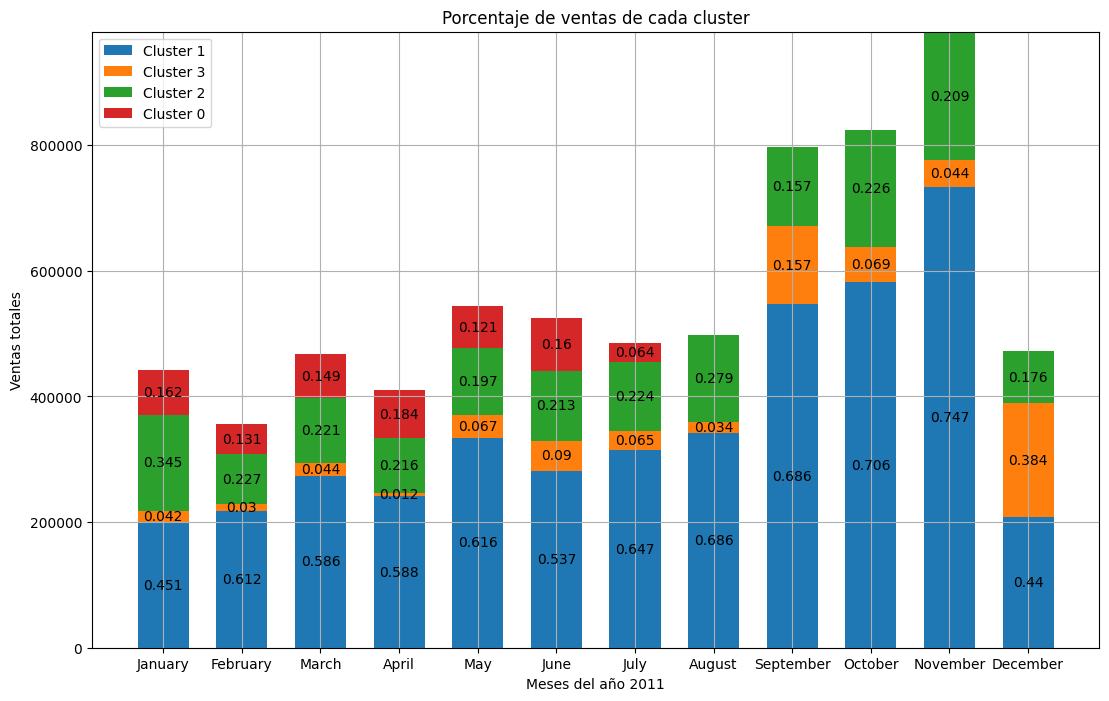

In [273]:


species = ('Adelie', 'Chinstrap', 'Gentoo')
sex_counts = {
    'Male': np.array([73, 34, 61]),
    'Female': np.array([73, 34, 58]),
}

width = 0.65 # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots( figsize=(13, 8))

bottom = np.zeros(12)

for cluster in [1, 3, 2, 0]:

  p = ax.bar(df.Month_name, df[f'IncomeCluster_{cluster}'], width, label=f'Cluster {cluster}', bottom=bottom)
  bottom += df[f'IncomeCluster_{cluster}']

  ax.bar_label(p, label_type='center', labels= round(df[f'IncomeCluster_{cluster}']/df['TotalIncome'], 3))

ax.set_title('Porcentaje de ventas de cada cluster')
ax.set_xlabel('Meses del año 2011')
ax.set_ylabel('Ventas totales')

ax.legend()
plt.grid()
plt.show()

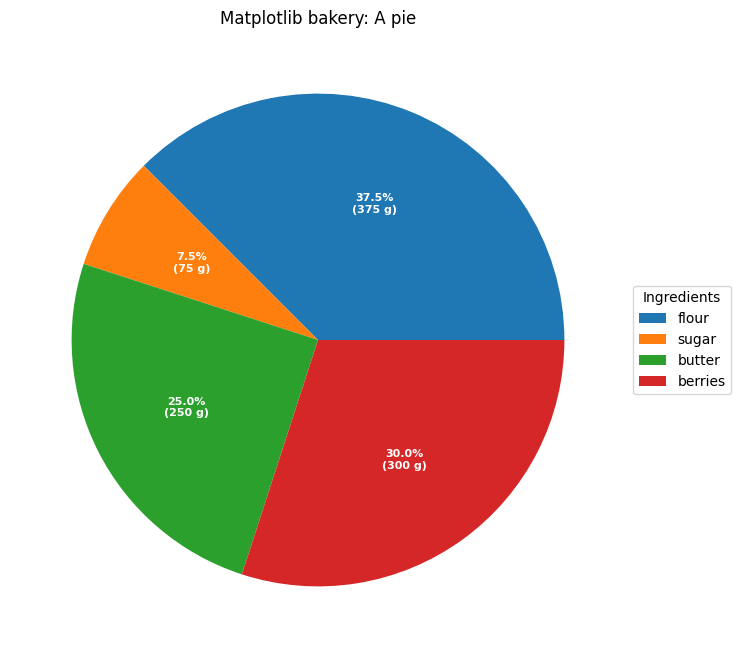

In [275]:

fig, ax = plt.subplots(figsize=(13,8), subplot_kw=dict(aspect="equal"))

recipe = ["375 g flour",
          "75 g sugar",
          "250 g butter",
          "300 g berries"]

data = [float(x.split()[0]) for x in recipe]
ingredients = [x.split()[-1] for x in recipe]


def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return f"{pct:.1f}%\n({absolute:d} g)"


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))

ax.legend(wedges, ingredients,
          title="Ingredients",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=8, weight="bold")

ax.set_title("Matplotlib bakery: A pie")

plt.show()